# Project Description

**A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Malignant tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors.**

**Artificial intelligence (AI) algorithms, particularly Deep learning, have shown remarkable progress in image-recognition jobs. Practices ranging from convolutional neural networks(CNN) to variational autoencoders have found innumerable applications in the medical image analysis field, driving it forward at a rapid pace. In radiology, trained physicians visually evaluated medical images for the detection, characterization, and monitoring of diseases. AI algorithms outshine at automatically recognizing complex patterns in imaging data and producing quantitative, rather than qualitative, evaluations of radiographic features.**

**Credits - Please refer to this article for more details https://www.theaidream.com/post/brain-tumor-detection-using-mask-r-cnn**

# Installing imutils package

In [1]:
!pip3 install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=0cd884da3761198145a2fd4a1f930c3c1998a039967ac28eb2a6314850ce7acd
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Importing the required libraries

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

# Loading the images

In [3]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("../input/brain-mri-images-for-brain-tumor-detection"))
data = []
labels = []

for imagePath in imagePaths:

	label = imagePath.split(os.path.sep)[-2]


	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))


	data.append(image)
	labels.append(label)


data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

[INFO] loading images...


# Training the data augmented object and loading the VGG16 model

In [4]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20,
                                                  stratify=labels, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

# load the VGG16 network, ensuring the head fully connected layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 1s 0us/step


# Building the model

In [5]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [6]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

**Initialising learning rate as 1e-3 , epochs as 25 and batch size as 8**

In [7]:
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


# Training the model

In [8]:
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/25
50/50 [==============================] - 6s 118ms/step - loss: 0.7205 - accuracy: 0.5960 - val_loss: 0.5602 - val_accuracy: 0.7745
Epoch 2/25
50/50 [==============================] - 5s 104ms/step - loss: 0.5901 - accuracy: 0.6894 - val_loss: 0.4957 - val_accuracy: 0.7843
Epoch 3/25
50/50 [==============================] - 5s 97ms/step - loss: 0.5159 - accuracy: 0.7702 - val_loss: 0.4429 - val_accuracy: 0.8725
Epoch 4/25
50/50 [==============================] - 5s 93ms/step - loss: 0.5118 - accuracy: 0.7525 - val_loss: 0.4178 - val_accuracy: 0.8922
Epoch 5/25
50/50 [==============================] - 5s 98ms/step - loss: 0.4676 - accuracy: 0.7828 - val_loss: 0.4547 - val_accuracy: 0.7941
Epoch 6/25
50/50 [==============================] - 5s 92ms/step - loss: 0.4394 - accuracy: 0.8005 - val_loss: 0.3628 - val_accuracy: 0.8824
Epoch 7/25
50/50 [==============================] - 5s 93ms/step - loss: 0.4620 - accuracy: 0.7778 - val_loss: 0.3428 - val_accu

# Evaluating the model

In [9]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[INFO] evaluating network...
              precision    recall  f1-score   support

          no       0.88      0.95      0.92        40
         yes       0.97      0.92      0.94        62

    accuracy                           0.93       102
   macro avg       0.92      0.93      0.93       102
weighted avg       0.93      0.93      0.93       102

[[38  2]
 [ 5 57]]
acc: 0.9314
sensitivity: 0.9500
specificity: 0.9194


**There are 95 correct observations out of 102 (total observations)**

# Plotting the training and validation with respect to loss and accuracy

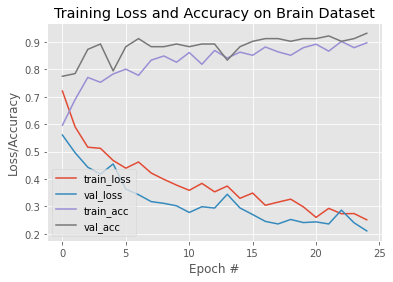

In [10]:
#plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.jpg")

# Saving the model

In [12]:
# serialize the model to disk
print("[INFO] saving Brain Tumor detector model...")
model.save("brain.model", save_format="h5")

[INFO] saving Brain Tumor detector model...


# Result

**We are getting an accuracy of 93% with Sensitivity as 0.95 and Specificity as 0.91**